<a href="https://colab.research.google.com/github/EmanuelAlogna/MRI-generation/blob/master/results/pix2pix_(P2P_t2)_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython import display
import time
import math

print(tf.__version__)

from google.colab import drive
drive.mount('/content/drive')

2.0.0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading train, validation and test sets

In [0]:
def get_feature_description(modalities):                                                   
                                                                                           
    feature_description =lambda mod : {                                                    
                            mod+'_mri': tf.io.FixedLenFeature([], tf.string),              
                            mod+'_path': tf.io.FixedLenFeature([], tf.string),             
                                                                                           
                            mod+'_mri_min': tf.io.FixedLenFeature([], tf.float32),         
                            mod+'_mri_min_src': tf.io.FixedLenFeature([], tf.float32),     
                            mod+'_mri_max': tf.io.FixedLenFeature([], tf.float32),         
                            mod+'_mri_max_src': tf.io.FixedLenFeature([], tf.float32),     
                                                                                           
                            mod+'_mri_lperc': tf.io.FixedLenFeature([], tf.float32),       
                            mod+'_mri_hperc': tf.io.FixedLenFeature([], tf.float32),       
                            mod+'_mri_hperc_src': tf.io.FixedLenFeature([], tf.float32),   
                            mod+'_mri_lperc_src': tf.io.FixedLenFeature([], tf.float32),   
                                                                                           
                            mod+'_x_dimension': tf.io.FixedLenFeature([], tf.int64),       
                            mod+'_y_dimension': tf.io.FixedLenFeature([], tf.int64),       
                            mod+'_z_dimension': tf.io.FixedLenFeature([], tf.int64),       
                            mod+'_z_dimension_src': tf.io.FixedLenFeature([], tf.int64),   
                            mod+'_x_dimension_src': tf.io.FixedLenFeature([], tf.int64),   
                            mod+'_y_dimension_src': tf.io.FixedLenFeature([], tf.int64),   
                                                                                           
                            mod+'_x_origin_src': tf.io.FixedLenFeature([], tf.float32),    
                            mod+'_y_origin_src': tf.io.FixedLenFeature([], tf.float32),    
                            mod+'_z_origin_src': tf.io.FixedLenFeature([], tf.float32),    
                                                                                           
                            mod+'_z_spacing_src': tf.io.FixedLenFeature([], tf.float32),   
                            mod+'_x_spacing_src': tf.io.FixedLenFeature([], tf.float32),   
                            mod+'_y_spacing_src': tf.io.FixedLenFeature([], tf.float32),   
                                                                                           
                            mod+'_patient': tf.io.FixedLenFeature([], tf.string),          
                            mod+'_sample_number': tf.io.FixedLenFeature([], tf.string),    
                            mod+'_patient_grade': tf.io.FixedLenFeature([], tf.string),    
                            mod+'_location': tf.io.FixedLenFeature([], tf.string),         
                            mod+'_dataset_version': tf.io.FixedLenFeature([], tf.string),  
                            mod+'_dataset_name': tf.io.FixedLenFeature([], tf.string),     
                            mod+'_mri_type': tf.io.FixedLenFeature([], tf.string),         
                            mod+'_dataset_split': tf.io.FixedLenFeature([], tf.string),    
                            mod+'_patient_mri_seq': tf.io.FixedLenFeature([], tf.string),  
                          }                                                                
    features = {}                                                                          
    for mod in modalities:
        features.update(feature_description(mod))
    return features

In [0]:
#BUFFER_SIZE = 400
BATCH_SIZE = 32

In [0]:
use_gzip_compression = True

def load_dataset(name, mri_type, center_crop=None, random_crop=None, filter=None, batch_size=BATCH_SIZE, cache=True, 
                 prefetch_buffer=1, shuffle_buffer=128, interleave=1, cast_to=tf.float32, clip_labels_to=0.0, 
                 take_only=None, shuffle=True, infinite=False, n_threads=os.cpu_count()):
    def parse_sample(sample_proto):
        parsed = tf.io.parse_single_example(sample_proto, get_feature_description(["OT"]+mri_type))
        # Decoding image arrays
        
        slice_shape = [parsed['OT_x_dimension'.format(mri_type[0])], parsed['OT_y_dimension'], 1]
        # Decoding the ground truth
        parsed['seg'] = tf.cast(tf.reshape(tf.io.decode_raw(parsed['OT_mri'], tf.float32), shape=slice_shape), dtype=cast_to)
        # Decode each channel and stack in a 3d volume
        stacked_mri = list()
        for mod in mri_type:
            stacked_mri.append(tf.cast(tf.reshape(tf.io.decode_raw(parsed['{}_mri'.format(mod)], tf.float32), shape=slice_shape), dtype=cast_to))
        parsed['mri'] = tf.concat(stacked_mri, axis=-1)
        # Clipping the labels if requested
        parsed['seg'] = tf.clip_by_value(parsed['seg'], 0.0, clip_labels_to) if clip_labels_to else parsed['seg']
        
        # Cropping
        if random_crop or center_crop:
            # Stacking the mri and the label to align the crop shape
            mri_seg = tf.concat([parsed['mri'], parsed['seg']], axis=-1)
            if random_crop:
                random_crop[-1] = mri_seg.shape[-1] 
                cropped = tf.image.random_crop(mri_seg, size=random_crop)
            else:
                cropped = tf.image.resize_with_crop_or_pad(mri_seg,center_crop[0],center_crop[1])
            # Splitting back
            parsed['mri'] = cropped[:,:,:len(mri_type)]
            parsed['seg'] = cropped[:,:,len(mri_type):]
        
        return parsed
    
    path = './drive/My Drive/MRI-generation/{}.tfrecords'.format(name)
    dataset = tf.data.TFRecordDataset(path, compression_type='GZIP' if use_gzip_compression else "")
    dataset = dataset.filter(filter) if filter is not None else dataset
    dataset = dataset.take(take_only) if take_only is not None else dataset

    # You should generally cache after loading and preprocessing the data, 
    # but before shuffling, repeating, batching and prefetching”
    dataset = dataset.cache() if cache else dataset
    if shuffle and infinite:
        dataset = dataset.apply(tf.data.experimental.shuffle_and_repeat(shuffle_buffer))
    else:
        dataset = dataset.shuffle(shuffle_buffer, reshuffle_each_iteration=True) if shuffle else dataset
        dataset = dataset.repeat() if infinite else dataset
    dataset = dataset.map(parse_sample, num_parallel_calls=None)
    dataset = dataset.batch(batch_size) if batch_size > 0 else dataset
    

    if interleave > 1:
        dataset = dataset.interleave(lambda x: tf.data.Dataset.from_tensors(x).repeat(interleave), cycle_length=n_threads, block_length=interleave, num_parallel_calls=n_threads)
  
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [0]:
# loading all the dataset, with only modality T1 and T2
# I'll focus now on synthesizing T2 from T1

def load_datasets():
    validation = load_dataset('brats2015_validation_crop_mri', ['MR_T1', 'MR_T2'])
    training = load_dataset('brats2015_training_crop_mri', ['MR_T1', 'MR_T2'])
    testing = load_dataset('brats2015_testing_crop_mri', ['MR_T1', 'MR_T2'])
    return training, validation , testing

In [0]:
training, validation, testing = load_datasets() # I'll use this in case I get stuck with the cache.

modalities = ['MR_T1_mri', 'MR_T2_mri', 'OT_mri']

## Load some useful functions


In [0]:
# PROCESSING IMAGES IN THE BATCH
def process_batch(batch):   # takes in input a raw_record[mod].numpy()
    batch = tf.io.decode_raw(batch, tf.float32)
    batch = tf.reshape(batch, (BATCH_SIZE, 180, 180))
    paddings = tf.constant([[0, 0], [38, 38], [38, 38]])
    batch = tf.pad(batch, paddings, "CONSTANT")
    batch = tf.expand_dims(batch, axis=3)
    return batch
    
# final shape will be (bs, 256, 256, 1): now the batch is ready to be fed to the GAN

In [0]:
# this function preprocesses the input image and the ground truth from a raw_record
# images in the return are then ready to be fed into the GAN
def take_images_from_raw(raw_record, ot=False):

    inp, ground_truth = raw_record[modalities[0]], raw_record[modalities[1]]
    inp = process_batch(inp)
    ground_truth = process_batch(ground_truth)
    if ot:      # if ot is true, I'll retrieve also the segmentation from the raw_record
        segmentation = process_batch(raw_record[modalities[2]])
        return inp, ground_truth, segmentation
    return inp, ground_truth

In [0]:
def resize_with_crop(*args): # possibile arguments: input, gt, prediction and maybe the segmentation

    image0 = tf.image.resize_with_crop_or_pad(args[0], 155, 194)
    image1 = tf.image.resize_with_crop_or_pad(args[1], 155, 194)
    image2 = tf.image.resize_with_crop_or_pad(args[2], 155, 194)
    if len(args) == 4:      # crop also the segmentation, if is given as additional argument
        image3 = tf.image.resize_with_crop_or_pad(args[3], 155, 194)
        return image0, image1, image2, image3
    return image0, image1, image2

In [0]:
def retrieve_tumor_area(ground_truth, prediction, segmentation):
    ground_truth_np = ground_truth.numpy()
    segmentation_np = segmentation.numpy()
    prediction_np = prediction.numpy()

    # I want to remove all the pixels not relevant wrt the tumor area. 
    idx = (segmentation_np==0)      
    ground_truth_np[idx] = segmentation_np[idx]
    prediction_np[idx] = segmentation_np[idx]

    return ground_truth_np, prediction_np      # Now the images are ready to be evaluated

In [0]:
def evaluate_GAN(model, dataset, set_type, evaluate_tumor_area=False):
    num_batches = 0                 # CAREFUL when batch_size is modified!!!
    if set_type == 'test':
        num_batches = 112           # in the test set, with batch 32, there are 112 elements.
    elif set_type == 'validation':
        num_batches = 108
    elif set_type == 'train':
        num_batches = 876
    container_psnr = tf.TensorArray(tf.float32, size=num_batches)     
    container_mse = tf.TensorArray(tf.float32, size=num_batches)
    container_ssim = tf.TensorArray(tf.float32, size=num_batches)
    
    if evaluate_tumor_area:
        container_psnr_tumor = tf.TensorArray(tf.float32, size=num_batches)     
        container_mse_tumor = tf.TensorArray(tf.float32, size=num_batches)
        container_ssim_tumor = tf.TensorArray(tf.float32, size=num_batches)
    
    for idx, raw_record in dataset.enumerate():
        inp, ground_truth, segmentation = take_images_from_raw(raw_record, ot=True)
        # generate the prediction        
        prediction = model(inp, training=False)
        # crop the images
        inp_cr, ground_truth_cr, prediction_cr, segmentation_cr = resize_with_crop(inp, ground_truth, prediction, segmentation)
        if idx == 0:
            prediction = plot_images(inp_cr, ground_truth_cr, prediction_cr)
        
        # normalize the prediction and the ground_truth
        prediction_normalized_cr = mean_normalize(prediction_cr)
        ground_truth_normalized_cr = mean_normalize(ground_truth_cr)

        # compute the metrics of similarity
        mean, std, psnr = compute_psnr(ground_truth_normalized_cr, prediction_normalized_cr)
        container_psnr = container_psnr.write(idx, psnr)
        mean, std, mse = compute_mse(ground_truth_normalized_cr, prediction_normalized_cr)
        container_mse = container_mse.write(idx, mse)
        mean, std, ssim = compute_ssim(ground_truth_normalized_cr, prediction_normalized_cr)
        container_ssim = container_ssim.write(idx, ssim)

        if evaluate_tumor_area:
            # discard black images from pred and gt
            ground_truth_masked, prediction_masked = retrieve_tumor_area(ground_truth_cr, prediction_cr, segmentation_cr)
            prediction_masked_normalized = mean_normalize(prediction_masked)
            ground_truth_masked_normalized = mean_normalize(ground_truth_masked) 
            
            mean, std, psnr = compute_psnr(ground_truth_masked_normalized, prediction_masked_normalized)
            container_psnr_tumor = container_psnr_tumor.write(idx, psnr)
            mean, std, mse = compute_mse(ground_truth_masked_normalized, prediction_masked_normalized)
            container_mse_tumor = container_mse_tumor.write(idx, mse)
            mean, std, ssim = compute_ssim(ground_truth_masked_normalized, prediction_masked_normalized)
            container_ssim_tumor = container_ssim_tumor.write(idx, ssim)
    
    container_psnr = container_psnr.stack()
    container_mse = container_mse.stack()
    container_ssim = container_ssim.stack()
    mean_psnr = tf.reduce_mean(tf.boolean_mask((container_psnr), tf.math.is_finite(container_psnr)))
    std_psnr = tf.math.reduce_std(tf.boolean_mask((container_psnr), tf.math.is_finite(container_psnr)))
    mean_mse = tf.reduce_mean(tf.boolean_mask((container_mse), tf.math.is_finite(container_mse)))
    std_mse = tf.math.reduce_std(tf.boolean_mask((container_mse), tf.math.is_finite(container_mse)))
    mean_ssim = tf.reduce_mean(tf.boolean_mask((container_ssim), tf.math.is_finite(container_ssim)))
    std_ssim = tf.math.reduce_std(tf.boolean_mask((container_ssim), tf.math.is_finite(container_ssim)))

    print("PSNR on {} set: {} ± {}".format(set_type, (f'{mean_psnr:.4f}'), (f'{std_psnr:.4f}')))
    print("MSE on {} set: {} ± {}".format(set_type, (f'{mean_mse:.4f}'), (f'{std_mse:.4f}')))
    print("SSIM on {} set: {} ± {}".format(set_type, (f'{mean_ssim:.4f}'), (f'{std_ssim:.4f}')))

    if evaluate_tumor_area:
        container_psnr_tumor = container_psnr_tumor.stack()
        container_mse_tumor = container_mse_tumor.stack()
        container_ssim_tumor = container_ssim_tumor.stack()
        mean_psnr_tumor = tf.reduce_mean(tf.boolean_mask((container_psnr_tumor), tf.math.is_finite(container_psnr_tumor)))
        std_psnr_tumor = tf.math.reduce_std(tf.boolean_mask((container_psnr_tumor), tf.math.is_finite(container_psnr_tumor)))
        mean_mse_tumor = tf.reduce_mean(tf.boolean_mask((container_mse_tumor), tf.math.is_finite(container_mse_tumor)))
        std_mse_tumor = tf.math.reduce_std(tf.boolean_mask((container_mse_tumor), tf.math.is_finite(container_mse_tumor)))
        mean_ssim_tumor = tf.reduce_mean(tf.boolean_mask((container_ssim_tumor), tf.math.is_finite(container_ssim_tumor)))
        std_ssim_tumor = tf.math.reduce_std(tf.boolean_mask((container_ssim_tumor), tf.math.is_finite(container_ssim_tumor)))
        print()
        print("PSNR wrt tumor area on {} set: {} ± {}".format(set_type, (f'{mean_psnr_tumor:.4f}'), (f'{std_psnr_tumor:.4f}')))
        print("MSE wrt tumor area on {} set: {} ± {}".format(set_type, (f'{mean_mse_tumor:.4f}'), (f'{std_mse_tumor:.4f}')))
        print("SSIM wrt tumor area on {} set: {} ± {}".format(set_type, (f'{mean_ssim_tumor:.4f}'), (f'{std_ssim_tumor:.4f}')))
        return mean_psnr, mean_mse, mean_ssim, mean_psnr_tumor, mean_mse_tumor, mean_ssim_tumor
    return mean_psnr, mean_mse, mean_ssim

In [0]:
def plot_metrics(psnr, mse, ssim, psnr_t, mse_t, ssim_t):
    f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))
    f.subplots_adjust(hspace=0.4)

    max_epoch = psnr.shape[0]

    epoch_list = list(range(1,max_epoch+1))
    ax1.plot(epoch_list, psnr, label='PSNR')
    ax1.plot(epoch_list, psnr_t, label='PSNR on tumor area')
    ax1.set_xticks(np.arange(1, max_epoch, 5))
    ax1.set_ylabel('PSNR Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('PSNR')
    l1 = ax1.legend(loc="best")

    ax2.plot(epoch_list, mse, label='MSE')
    ax2.plot(epoch_list, mse_t, label='MSE on tumor area')
    ax2.set_xticks(np.arange(1, max_epoch, 5))
    ax2.set_ylabel('MSE Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('MSE')
    l2 = ax2.legend(loc="best")

    ax3.plot(epoch_list, ssim, label='SSIM')
    ax3.plot(epoch_list, ssim_t, label='SSIM on tumor area')
    ax3.set_xticks(np.arange(1, max_epoch, 5))
    ax3.set_ylabel('SSIM Value')
    ax3.set_xlabel('Epoch')
    ax3.set_title('SSIM')
    l3 = ax3.legend(loc="best")


In [0]:
# this method was tested to work with 5 and 32 images. Plotting 2, 3 or 4 types per time.

def plot_images(*args, images_to_print=5): 
    if images_to_print == 5: x = 15
    elif images_to_print == 32: x = 90
    if len(args) == 3:
        display_list = [args[0], args[1], args[2]]     # input, gt and prediction
        title = ['Input Image', 'Ground Truth', 'Predicted Image']
        figsize = (x , 9)
    elif len(args) == 2:
        display_list = [args[0], args[1]]     # input and gt
        title = ['Input Image', 'Ground Truth']
        figsize = (x , 7)
    elif len(args) == 4:
        display_list = [args[0], args[1], args[2], args[3]]     # gt, prediction, gt_masked, prediction_masked
        title = ['Ground Truth', 'Prediction', 'GT in tumor area', 'Pred in tumor area']
        figsize = (x , 12)
    plt.figure(1 , figsize)
    n = 0
    for i in range(len(args)):
        for j in range(images_to_print):    # batch size is different from 10, but let's show just 10 images.
            n += 1
            plt.subplot(len(args)+1, images_to_print, n).title.set_text(title[i])
            plt.imshow(tf.squeeze(display_list[i][j]), cmap='bone')
            plt.axis('off')
    plt.show()
    print()

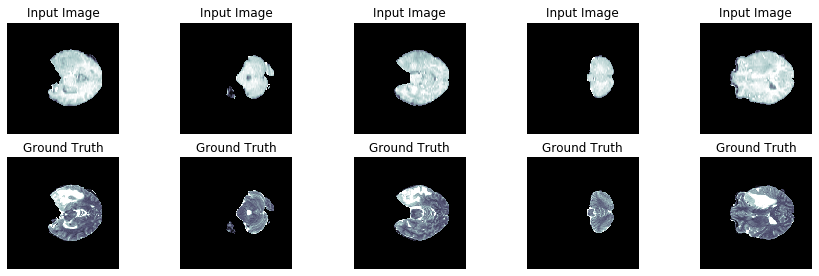

In [15]:
for raw_record in testing.take(1):
    #inp, ground_truth, segmentation = take_images_from_raw(raw_record, True)
    inp, ground_truth = take_images_from_raw(raw_record)

    plot_images(inp, ground_truth)

## Min-max normalization

![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/73032b45bffd5e5140483fbe1ed49bf174f1962d)

In [0]:
def min_max_rescale(x, xmin, xmax, a, b):
    return (a + (b-a)*(x-xmin)/(xmax-xmin))  
    # to rescale in the range [0, 1], 'a' must be 0 and 'b' = 1

In [0]:
@tf.function
def min_max_normalize(image):
    image_normalized = tf.TensorArray(tf.float32, size=BATCH_SIZE)
    for i in range(BATCH_SIZE):
        # rescaling each image in the batch
        max_value = tf.math.reduce_max(image[i])
        min_value = tf.math.reduce_min(image[i])
        x = min_max_rescale(image[i], min_value, max_value, 0, 1)
        image_normalized = image_normalized.write(i, x)
    image_normalized = image_normalized.stack()
    return image_normalized

## Mean normalization

![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/5c591a0eeba163a12f69f937adbae5886d6273db)

In the paper they say: "Each patient scan is normalized by dividing each sequence by its mean intensity value. "
But the formula is taken from a lecture from Andrew Ng, where he defines the Mean normalization as in the formula above. (resource: https://www.youtube.com/watch?v=e1nTgoDI_m8)

See also: https://stats.stackexchange.com/questions/138046/normalizations-dividing-by-mean

In [0]:
def mean_rescale(x, xmin, xmax):
    mean = tf.reduce_mean(x)
    return ((x-mean)/(xmax-xmin)) 

In [0]:
@tf.function
def mean_normalize(image):
    image_normalized = tf.TensorArray(tf.float32, size=BATCH_SIZE)
    for i in range(BATCH_SIZE):
        # rescaling each image in the batch
        max_value = tf.math.reduce_max(image[i])
        min_value = tf.math.reduce_min(image[i])
        x = mean_rescale(image[i], min_value, max_value)
        image_normalized = image_normalized.write(i, x)
    image_normalized = image_normalized.stack()
    return image_normalized
    

## Discard black images from batch (put values to 'nan')

This normalization is just to test the metrics and see if there is a big difference in normalizing the prediction and the gt.
This method is used to normalize (and so put to 'nan') only the black images, while the other images of the batch are kept with the original values. This allows me to discard the black images in the computation of the metrics.

In [0]:
def black_images_to_nan(image): 
    image_normalized = tf.TensorArray(tf.float32, size=BATCH_SIZE)
    for i in range(BATCH_SIZE):
        # rescaling each image in the batch
        max_value = tf.math.reduce_max(image[i])
        min_value = tf.math.reduce_min(image[i])

        # if the max = min most likely it's a black image (or an image without any important information)
        if tf.math.equal(max_value, min_value):        
            x = mean_rescale(image[i], min_value, max_value)
            image_normalized = image_normalized.write(i, x)
        else:
            image_normalized = image_normalized.write(i, image[i])
    image_normalized = image_normalized.stack()
    return image_normalized

##Defining all the quantitative metrics (PSNR, SSIM and MSE)

In [0]:
def compute_psnr(image1, image2):
    # Compute PSNR over tf.float32 Tensors.
    im1 = tf.image.convert_image_dtype(image1, tf.float32)   # inp is a numpy.ndarray and im1 is an EagerTensor
    im2 = tf.image.convert_image_dtype(image2, tf.float32)
    psnr = tf.image.psnr(im1, im2, max_val=1.0)
    mean = tf.reduce_mean(tf.boolean_mask((psnr), tf.math.is_finite(psnr)))
    std = tf.math.reduce_std(tf.boolean_mask((psnr), tf.math.is_finite(psnr)))
    # In the computation of mean and std, I'm ignoring the 'nan' and 'inf' values
    # Why 'nan' values? 'nan' happens when there is an image with max_value and min_value = 0.0 so a black image
    # the PSNR would be inf (image is totally similar to the ground truth)
    # be rescaling the image, the max_value and min_value would become nan and so the PSNR

    # It ignores also the 'inf' values, in the case I don't want to normalize
    
    return mean, std, psnr

In [0]:
def compute_ssim(image1, image2):
    im1 = tf.image.convert_image_dtype(image1, tf.float32)   # inp is a numpy.ndarray and im1 is an EagerTensor
    im2 = tf.image.convert_image_dtype(image2, tf.float32)
    ssim = tf.image.ssim(im1, im2, max_val=1)
    mean = tf.reduce_mean(tf.boolean_mask((ssim), tf.math.is_finite(ssim)))
    std = tf.math.reduce_std(tf.boolean_mask((ssim), tf.math.is_finite(ssim)))
    #print(ssim)
    return mean, std, ssim

In [0]:
# I want to compute, first thing, the MSE between ground truth and generated one. The tf.function gives me a Tensor 32x256x256:
# MSE is computed PIXEL per PIXEL, so per each of the 32 matrix 256x256, I average (1) the values of the 256x256 pixels obtaining
# an array of 32 elements, containing the MSEs of each image belonging to the batch. Then I can average (2) these 32 to have 
# I should not average the whole 32x256x256 in one step. The result would have same mean but slightly different std.
# I want first to obtain the MSE of each image... then I average across the batch only to have smth more accurate.

def compute_mse(image1, image2):       # mean squared error
    im1 = tf.image.convert_image_dtype(image1, tf.float32)   # inp is a numpy.ndarray and im1 is an EagerTensor
    im2 = tf.image.convert_image_dtype(image2, tf.float32)
    mse = tf.metrics.mean_squared_error(im1,im2)
    # In this way is possible to do Variable item-assignment with tensors 
    mse_per_image = tf.TensorArray(tf.float32, size=BATCH_SIZE)
    for i in range(BATCH_SIZE):
        x = tf.reduce_mean(tf.boolean_mask((mse[i]), tf.math.is_finite(mse[i]))) 
        mse_per_image = mse_per_image.write(i, x)
    mse_per_image = mse_per_image.stack()
    mean = tf.reduce_mean(tf.boolean_mask((mse_per_image), tf.math.is_finite(mse_per_image)))
    std = tf.math.reduce_std(tf.boolean_mask((mse_per_image), tf.math.is_finite(mse_per_image)))
    return mean, std, mse_per_image

## Defining models and optimizers

In [0]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
OUTPUT_CHANNELS = 1

In [0]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [0]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [0]:
# hint from the web: Unfortunately, UNet does not work with arbitrary input sizes. Try ResNet instead.

def Generator():
  inputs = tf.keras.layers.Input(shape=[256,256,1], batch_size=BATCH_SIZE)

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]
  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]
  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, padding='same',
                                         kernel_initializer=initializer,activation='tanh') # (bs, 256, 256, 1)
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [0]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)



  return total_gen_loss, gan_loss, l1_loss

In [0]:
generator = Generator()

In [0]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 1], name='input_image', batch_size=BATCH_SIZE)
  tar = tf.keras.layers.Input(shape=[256, 256, 1], name='target_image', batch_size=BATCH_SIZE)

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1) #(bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)
  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [0]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [0]:
discriminator = Discriminator()

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Let's load now the generator, discriminator weights and optimizers status from the checkpoints



Uncomment this only to continue to train an already trained network. Otherwise it will be trained a new GAN

In [35]:

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))

checkpoint_path = "./drive/My Drive/checkpoints/train"

ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer,
                                generator=generator,
                                discriminator=discriminator)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()


Optimizers and models defined but not initialized? True
Optimizers and models defined but not initialized? True



Now the GAN is restored to the previous checkpoint and ready to be trained again !!!

##**TRAIN THE GAN**

In [0]:
@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        # G produces fake images of T2
        gen_output = generator(input_image, training=True)

        # showing to D a batch of real images of T2
        disc_real_output = discriminator([input_image, target], training=True)
        
        # showing to D a batch fake images of T2
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)


    generator_gradients = gen_tape.gradient(gen_total_loss,
                                            generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                                discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                discriminator.trainable_variables))

    #return gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss

In [0]:
def fit(train_ds, epochs, val_ds, save_checkpoint, epochs_already_trained, tumor_area):

    psnr_to_plot = tf.TensorArray(tf.float32, size=epochs+1)
    mse_to_plot = tf.TensorArray(tf.float32, size=epochs+1)
    ssim_to_plot = tf.TensorArray(tf.float32, size=epochs+1) 
    if tumor_area:
        psnr_to_plot_tumor = tf.TensorArray(tf.float32, size=epochs+1)
        mse_to_plot_tumor = tf.TensorArray(tf.float32, size=epochs+1)
        ssim_to_plot_tumor = tf.TensorArray(tf.float32, size=epochs+1) 

    for epoch in range(epochs):
        if epoch == 0:
            psnr, mse, ssim, psnr_norm, mse_norm, ssim_norm = evaluate_GAN(generator, val_ds, 'validation', tumor_area)
            psnr_to_plot = psnr_to_plot.write(epoch, psnr)
            mse_to_plot = mse_to_plot.write(epoch, mse)
            ssim_to_plot = ssim_to_plot.write(epoch, ssim)
            if tumor_area:
                psnr_to_plot_tumor = psnr_to_plot_tumor.write(epoch, psnr_norm)
                mse_to_plot_tumor = mse_to_plot_tumor.write(epoch, mse_norm)
                ssim_to_plot_tumor = ssim_to_plot_tumor.write(epoch, ssim_norm)
            #ckpt_save_path = ckpt_manager.save()
        start = time.time()
        print()
        print("Epoch: ", epoch + 1 + epochs_already_trained)     # I start with epoch 1: the first iteration (not epoch 0)

        # Train
        n = 0
        #for raw_record in train_ds.take(10):
        for idx, raw_record in train_ds.enumerate():
            n += 1
            input_image, target = take_images_from_raw(raw_record)
            print('.', end='')
            if (n+1) % 100 == 0:
                print()
                print(n+1)
            # This is the actual TRAINING STEP
            train_step(input_image, target)
        # VALIDATE the results
        psnr, mse, ssim, psnr_tumor, mse_tumor, ssim_tumor = evaluate_GAN(generator, val_ds, 'validation', tumor_area)
        psnr_to_plot = psnr_to_plot.write(epoch+1, psnr)
        mse_to_plot = mse_to_plot.write(epoch + 1, mse)
        ssim_to_plot = ssim_to_plot.write(epoch +1 , ssim)
        if tumor_area:
            psnr_to_plot_tumor = psnr_to_plot_tumor.write(epoch+ 1, psnr_tumor)
            mse_to_plot_tumor = mse_to_plot_tumor.write(epoch+1, mse_tumor)
            ssim_to_plot_tumor = ssim_to_plot_tumor.write(epoch+1, ssim_tumor)
        print()

        # saving (checkpoint) the model every 5 epochs
        if (epoch + 1) % 5 == 0 and save_checkpoint:
            ckpt_save_path = ckpt_manager.save()
            print ('Saving checkpoint for epoch {} at {}'.format(epoch+ 1 + epochs_already_trained,
                                                         ckpt_save_path))

        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1 + epochs_already_trained,
                                                            time.time()-start))
    if save_checkpoint:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving {} checkpoint for epoch {} at {}'.format("FINAL", epoch+ 1 + epochs_already_trained,
                                                         ckpt_save_path))

    psnr_to_plot = psnr_to_plot.stack()
    mse_to_plot = mse_to_plot.stack()
    ssim_to_plot = ssim_to_plot.stack()
    if tumor_area:
        psnr_to_plot_tumor = psnr_to_plot_tumor.stack()
        mse_to_plot_tumor = mse_to_plot_tumor.stack()
        ssim_to_plot_tumor = ssim_to_plot_tumor.stack()
        return psnr_to_plot, mse_to_plot, ssim_to_plot, psnr_to_plot_tumor, mse_to_plot_tumor, ssim_to_plot_tumor
    return psnr_to_plot, mse_to_plot, ssim_to_plot

In [0]:
!pip install -q pyyaml h5py  # Required to save models in HDF5 format

## Fit of the model (at the end it will also save the models)

I save the models (I would need to save only the generator to be precise) in the same cell of the fitting because Google Colab, with long-run execution, doesn't allow to execute other cells after the one where I call 'fit'

Suggestion: train for around 35 epochs. Long-run are discouraged since Google Colab will crash.
Last time it arrived until the 43th epoch (409 seconds each).
So MAX TRAINING TIME ALLOWED: almost 5 hours. -> after that GPU won't be available for 8 hours or so

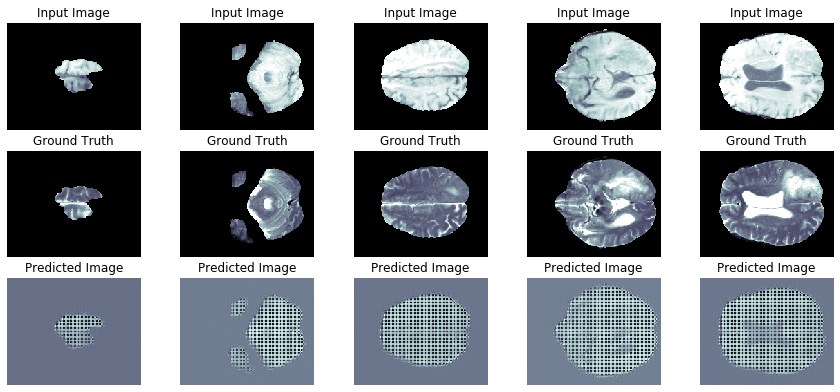


PSNR on validation set: 11.1781 ± 3.2042
MSE on validation set: 0.0895 ± 0.0375
SSIM on validation set: 0.1819 ± 0.1199

PSNR wrt tumor area on validation set: 18.5906 ± 9.6912
MSE wrt tumor area on validation set: 0.0285 ± 0.0231
SSIM wrt tumor area on validation set: 0.4397 ± 0.2677

Epoch:  1
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
....................................................................................................
600
.........................................................................

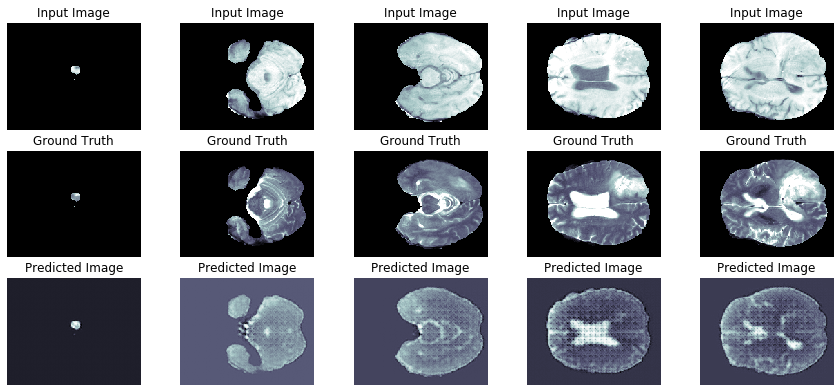


PSNR on validation set: 16.6368 ± 4.7287
MSE on validation set: 0.0320 ± 0.0226
SSIM on validation set: 0.5580 ± 0.2163

PSNR wrt tumor area on validation set: 25.3421 ± 13.3782
MSE wrt tumor area on validation set: 0.0122 ± 0.0152
SSIM wrt tumor area on validation set: 0.7790 ± 0.2132

Time taken for epoch 1 is 422.2833948135376 sec


Epoch:  2
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
....................................................................................................
600
......................

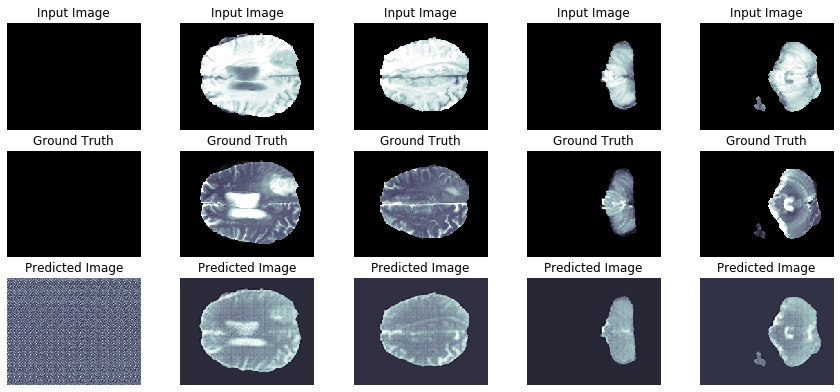


PSNR on validation set: 19.4977 ± 3.9739
MSE on validation set: 0.0152 ± 0.0105
SSIM on validation set: 0.7155 ± 0.1283

PSNR wrt tumor area on validation set: 29.6393 ± 12.6353
MSE wrt tumor area on validation set: 0.0042 ± 0.0053
SSIM wrt tumor area on validation set: 0.9292 ± 0.0688

Time taken for epoch 2 is 415.0391035079956 sec


Epoch:  3
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
....................................................................................................
600
......................


PSNR on validation set: 19.7181 ± 3.9352
MSE on validation set: 0.0143 ± 0.0099
SSIM on validation set: 0.7245 ± 0.1234

PSNR wrt tumor area on validation set: 30.0582 ± 12.5762
MSE wrt tumor area on validation set: 0.0038 ± 0.0049
SSIM wrt tumor area on validation set: 0.9363 ± 0.0634

Time taken for epoch 3 is 415.1629514694214 sec


Epoch:  4
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
....................................................................................................
600
......................

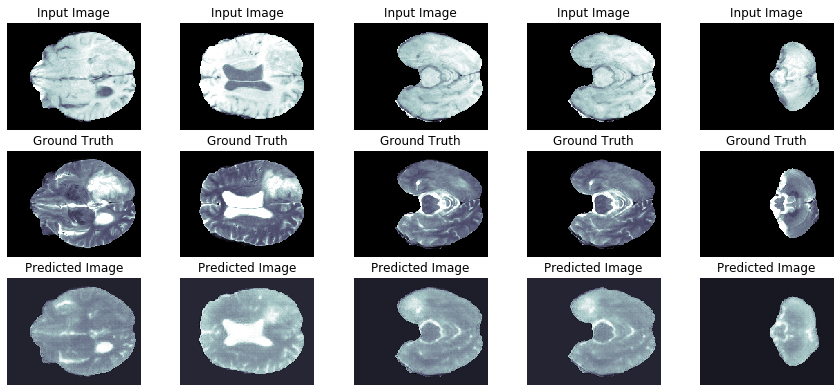


PSNR on validation set: 20.6510 ± 3.9384
MSE on validation set: 0.0117 ± 0.0087
SSIM on validation set: 0.7516 ± 0.1174

PSNR wrt tumor area on validation set: 31.1055 ± 11.6507
MSE wrt tumor area on validation set: 0.0031 ± 0.0043
SSIM wrt tumor area on validation set: 0.9478 ± 0.0561

Time taken for epoch 4 is 415.2087814807892 sec


Epoch:  5
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
....................................................................................................
600
......................


PSNR on validation set: 20.1931 ± 4.1862
MSE on validation set: 0.0135 ± 0.0105
SSIM on validation set: 0.7422 ± 0.1281

PSNR wrt tumor area on validation set: 30.3548 ± 12.5471
MSE wrt tumor area on validation set: 0.0039 ± 0.0057
SSIM wrt tumor area on validation set: 0.9356 ± 0.0743

Saving checkpoint for epoch 5 at ./drive/My Drive/checkpoints/train/ckpt-1
Time taken for epoch 5 is 418.5582377910614 sec


Epoch:  6
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
....................................................


PSNR on validation set: 21.6315 ± 3.7896
MSE on validation set: 0.0091 ± 0.0067
SSIM on validation set: 0.7855 ± 0.1058

PSNR wrt tumor area on validation set: 31.8294 ± 11.0369
MSE wrt tumor area on validation set: 0.0024 ± 0.0033
SSIM wrt tumor area on validation set: 0.9579 ± 0.0439

Time taken for epoch 6 is 414.72835397720337 sec


Epoch:  7
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
....................................................................................................
600
.....................


PSNR on validation set: 20.6222 ± 3.9809
MSE on validation set: 0.0118 ± 0.0085
SSIM on validation set: 0.7617 ± 0.1103

PSNR wrt tumor area on validation set: 31.2963 ± 12.0294
MSE wrt tumor area on validation set: 0.0028 ± 0.0040
SSIM wrt tumor area on validation set: 0.9512 ± 0.0528

Time taken for epoch 7 is 415.8891398906708 sec


Epoch:  8
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
....................................................................................................
600
......................


PSNR on validation set: 21.0551 ± 4.1515
MSE on validation set: 0.0113 ± 0.0096
SSIM on validation set: 0.7660 ± 0.1225

PSNR wrt tumor area on validation set: 31.1040 ± 11.7449
MSE wrt tumor area on validation set: 0.0033 ± 0.0053
SSIM wrt tumor area on validation set: 0.9442 ± 0.0711

Time taken for epoch 8 is 414.8717484474182 sec


Epoch:  9
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
....................................................................................................
600
......................

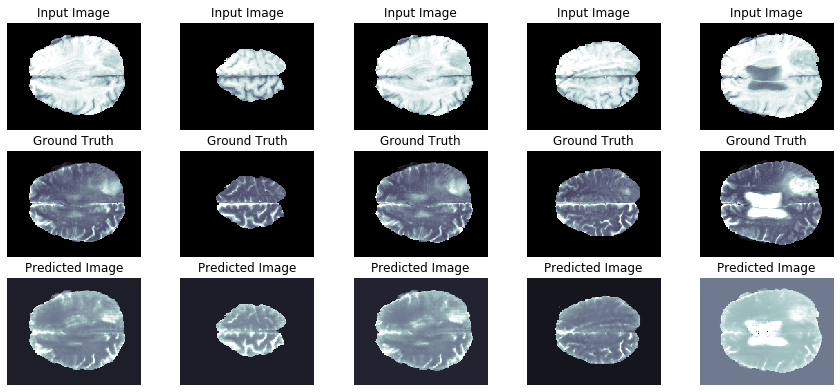


PSNR on validation set: 20.5515 ± 4.3101
MSE on validation set: 0.0129 ± 0.0113
SSIM on validation set: 0.7516 ± 0.1336

PSNR wrt tumor area on validation set: 30.2997 ± 13.2452
MSE wrt tumor area on validation set: 0.0041 ± 0.0061
SSIM wrt tumor area on validation set: 0.9316 ± 0.0814

Time taken for epoch 9 is 415.6355633735657 sec


Epoch:  10
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
....................................................................................................
600
.....................

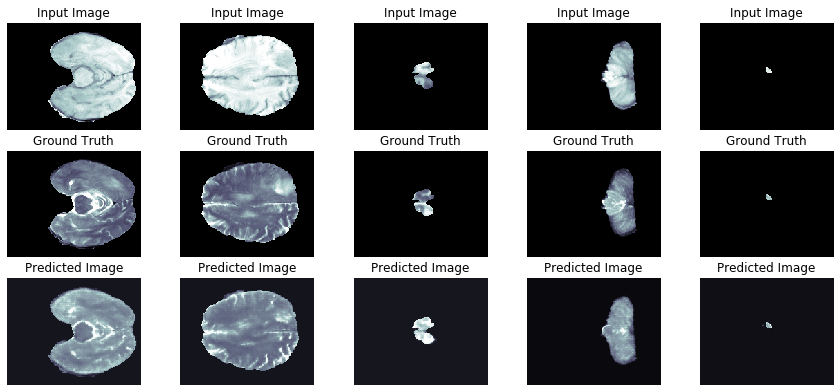


PSNR on validation set: 21.0186 ± 4.0911
MSE on validation set: 0.0112 ± 0.0094
SSIM on validation set: 0.7676 ± 0.1217

PSNR wrt tumor area on validation set: 30.5913 ± 12.7722
MSE wrt tumor area on validation set: 0.0036 ± 0.0052
SSIM wrt tumor area on validation set: 0.9397 ± 0.0679

Saving checkpoint for epoch 10 at ./drive/My Drive/checkpoints/train/ckpt-2
Time taken for epoch 10 is 417.42976999282837 sec


Epoch:  11
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
................................................

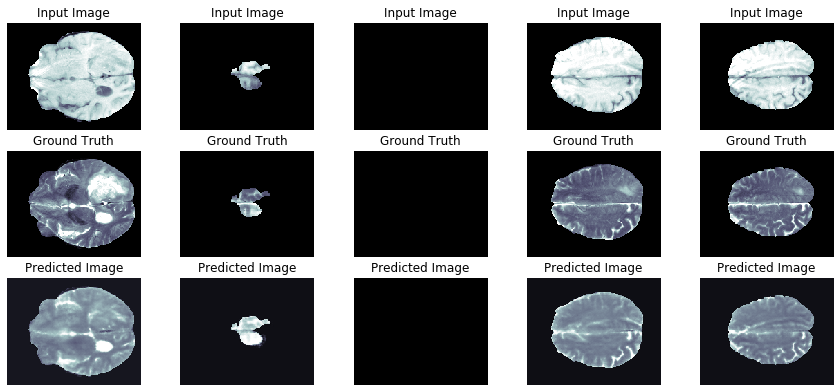


PSNR on validation set: 21.8490 ± 3.9540
MSE on validation set: 0.0090 ± 0.0071
SSIM on validation set: 0.7929 ± 0.1101

PSNR wrt tumor area on validation set: 31.8486 ± 12.7553
MSE wrt tumor area on validation set: 0.0027 ± 0.0040
SSIM wrt tumor area on validation set: 0.9538 ± 0.0534

Time taken for epoch 11 is 414.22463822364807 sec


Epoch:  12
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
....................................................................................................
600
...................

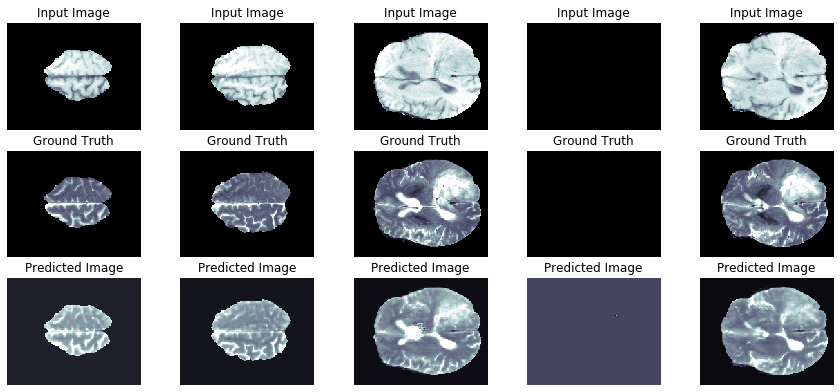


PSNR on validation set: 21.5865 ± 3.9371
MSE on validation set: 0.0095 ± 0.0074
SSIM on validation set: 0.7843 ± 0.1119

PSNR wrt tumor area on validation set: 31.0754 ± 12.9005
MSE wrt tumor area on validation set: 0.0031 ± 0.0042
SSIM wrt tumor area on validation set: 0.9475 ± 0.0553

Time taken for epoch 12 is 414.3828887939453 sec


Epoch:  13
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
....................................................................................................
600
....................

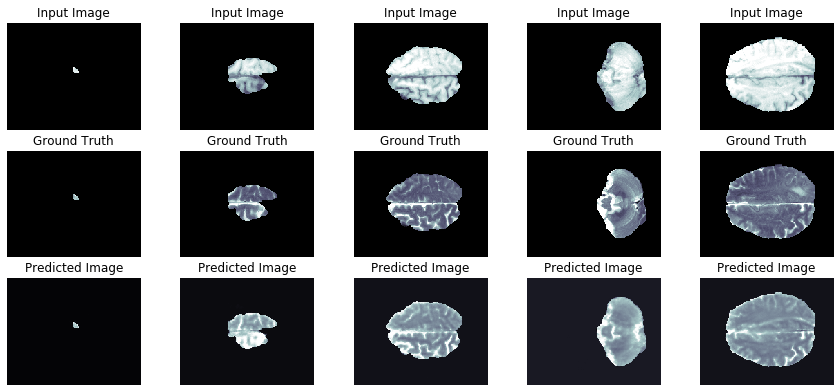


PSNR on validation set: 22.1136 ± 3.7742
MSE on validation set: 0.0082 ± 0.0060
SSIM on validation set: 0.8005 ± 0.1040

PSNR wrt tumor area on validation set: 31.5768 ± 12.3997
MSE wrt tumor area on validation set: 0.0026 ± 0.0035
SSIM wrt tumor area on validation set: 0.9547 ± 0.0470

Time taken for epoch 13 is 414.16321539878845 sec


Epoch:  14
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
....................................................................................................
600
...................

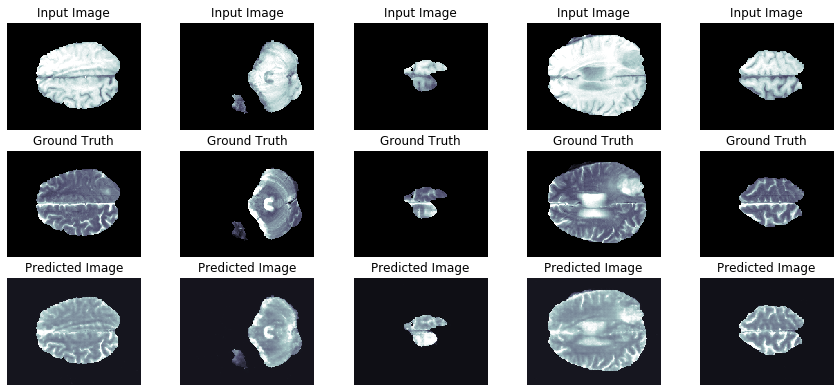


PSNR on validation set: 21.6549 ± 3.8778
MSE on validation set: 0.0093 ± 0.0074
SSIM on validation set: 0.7860 ± 0.1140

PSNR wrt tumor area on validation set: 31.4650 ± 12.1033
MSE wrt tumor area on validation set: 0.0026 ± 0.0035
SSIM wrt tumor area on validation set: 0.9528 ± 0.0500

Time taken for epoch 14 is 414.56111192703247 sec


Epoch:  15
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
....................................................................................................
600
...................

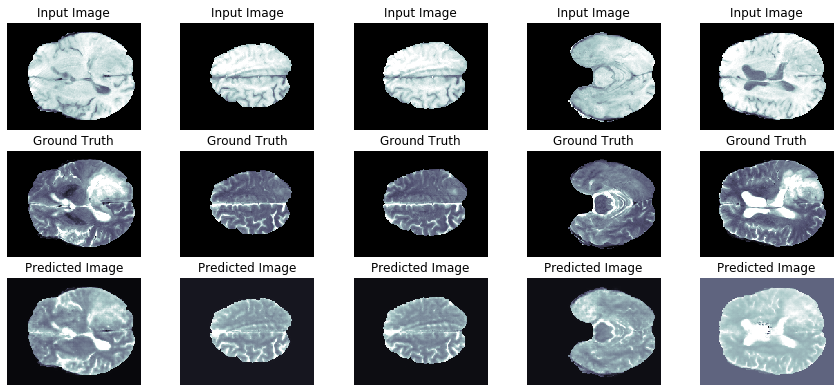


PSNR on validation set: 22.0089 ± 3.7115
MSE on validation set: 0.0083 ± 0.0060
SSIM on validation set: 0.7936 ± 0.1076

PSNR wrt tumor area on validation set: 31.8501 ± 12.5319
MSE wrt tumor area on validation set: 0.0024 ± 0.0032
SSIM wrt tumor area on validation set: 0.9573 ± 0.0436

Saving checkpoint for epoch 15 at ./drive/My Drive/checkpoints/train/ckpt-3
Time taken for epoch 15 is 417.92916989326477 sec


Epoch:  16
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
................................................

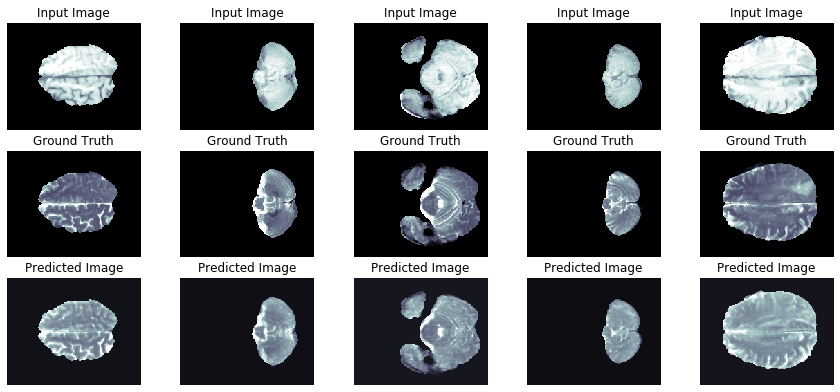


PSNR on validation set: 21.7588 ± 3.9207
MSE on validation set: 0.0093 ± 0.0077
SSIM on validation set: 0.7870 ± 0.1150

PSNR wrt tumor area on validation set: 31.4424 ± 12.0810
MSE wrt tumor area on validation set: 0.0027 ± 0.0038
SSIM wrt tumor area on validation set: 0.9519 ± 0.0530

Time taken for epoch 16 is 414.72879004478455 sec


Epoch:  17
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
....................................................................................................
600
...................

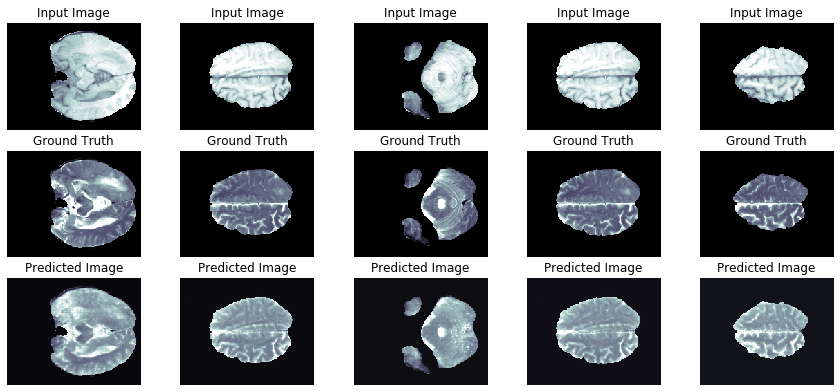


PSNR on validation set: 22.0312 ± 3.5828
MSE on validation set: 0.0081 ± 0.0055
SSIM on validation set: 0.7909 ± 0.1056

PSNR wrt tumor area on validation set: 31.5279 ± 12.1497
MSE wrt tumor area on validation set: 0.0025 ± 0.0032
SSIM wrt tumor area on validation set: 0.9552 ± 0.0445

Time taken for epoch 17 is 414.2585690021515 sec


Epoch:  18
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
....................................................................................................
600
....................

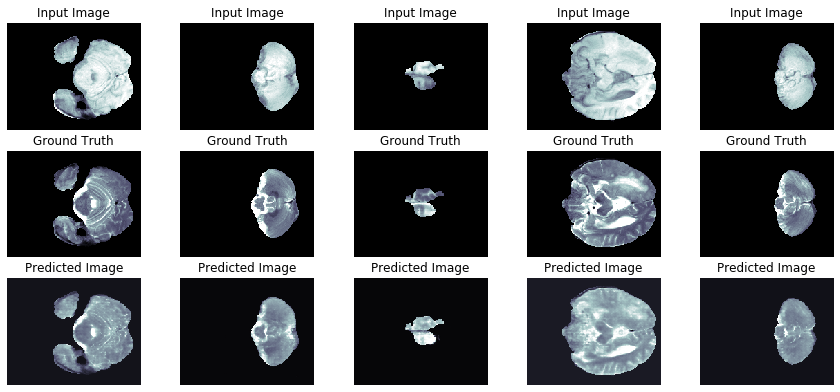


PSNR on validation set: 22.1911 ± 3.6372
MSE on validation set: 0.0078 ± 0.0054
SSIM on validation set: 0.7958 ± 0.1047

PSNR wrt tumor area on validation set: 31.7963 ± 11.9319
MSE wrt tumor area on validation set: 0.0024 ± 0.0032
SSIM wrt tumor area on validation set: 0.9571 ± 0.0435

Time taken for epoch 18 is 414.0690565109253 sec


Epoch:  19
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
....................................................................................................
600
....................

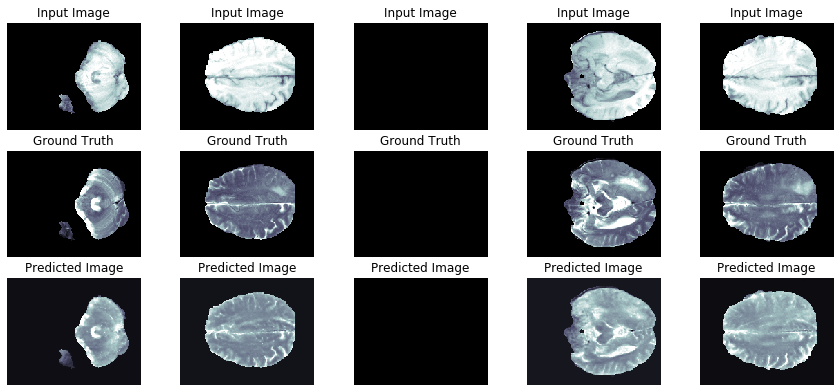


PSNR on validation set: 22.1416 ± 3.7173
MSE on validation set: 0.0080 ± 0.0055
SSIM on validation set: 0.7935 ± 0.1054

PSNR wrt tumor area on validation set: 31.5069 ± 11.7930
MSE wrt tumor area on validation set: 0.0024 ± 0.0031
SSIM wrt tumor area on validation set: 0.9551 ± 0.0440

Time taken for epoch 19 is 414.2634527683258 sec


Epoch:  20
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
....................................................................................................
600
....................

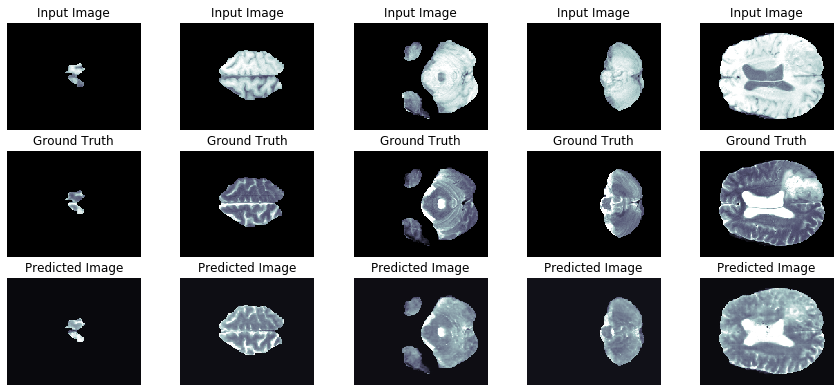


PSNR on validation set: 21.8944 ± 3.8559
MSE on validation set: 0.0087 ± 0.0062
SSIM on validation set: 0.7896 ± 0.1086

PSNR wrt tumor area on validation set: 31.1413 ± 13.2712
MSE wrt tumor area on validation set: 0.0029 ± 0.0038
SSIM wrt tumor area on validation set: 0.9489 ± 0.0514

Saving checkpoint for epoch 20 at ./drive/My Drive/checkpoints/train/ckpt-4
Time taken for epoch 20 is 417.5873792171478 sec


Epoch:  21
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
.................................................

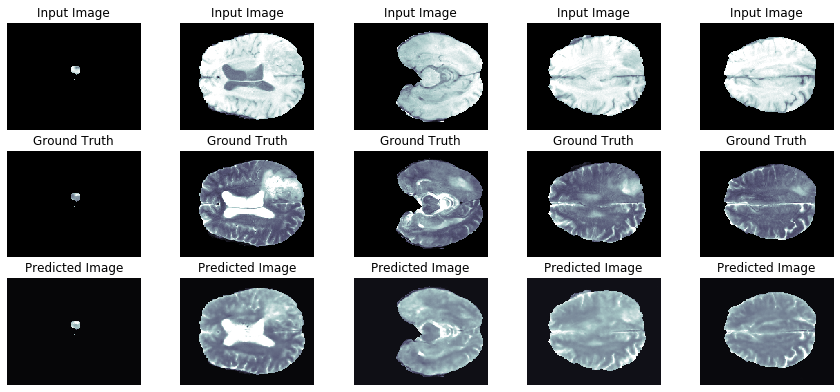


PSNR on validation set: 22.1478 ± 3.9156
MSE on validation set: 0.0083 ± 0.0063
SSIM on validation set: 0.8003 ± 0.1057

PSNR wrt tumor area on validation set: 31.7339 ± 12.6300
MSE wrt tumor area on validation set: 0.0026 ± 0.0035
SSIM wrt tumor area on validation set: 0.9552 ± 0.0473

Time taken for epoch 21 is 415.54970049858093 sec


Epoch:  22
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
....................................................................................................
600
...................

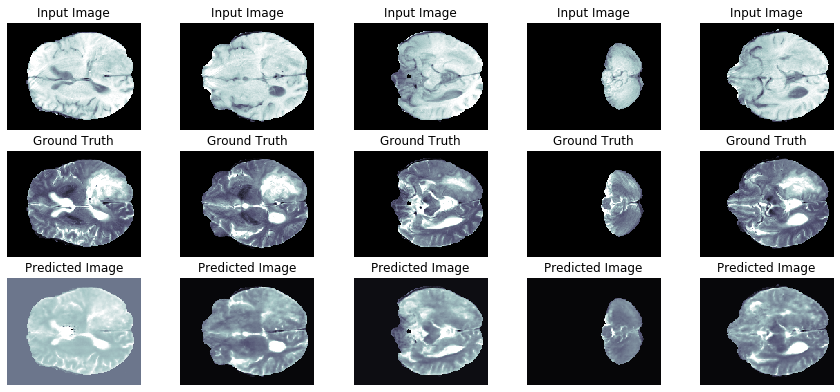


PSNR on validation set: 21.7568 ± 4.2384
MSE on validation set: 0.0098 ± 0.0087
SSIM on validation set: 0.7891 ± 0.1194

PSNR wrt tumor area on validation set: 31.3293 ± 12.8991
MSE wrt tumor area on validation set: 0.0031 ± 0.0047
SSIM wrt tumor area on validation set: 0.9470 ± 0.0643

Time taken for epoch 22 is 416.65488839149475 sec


Epoch:  23
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
....................................................................................................
600
...................

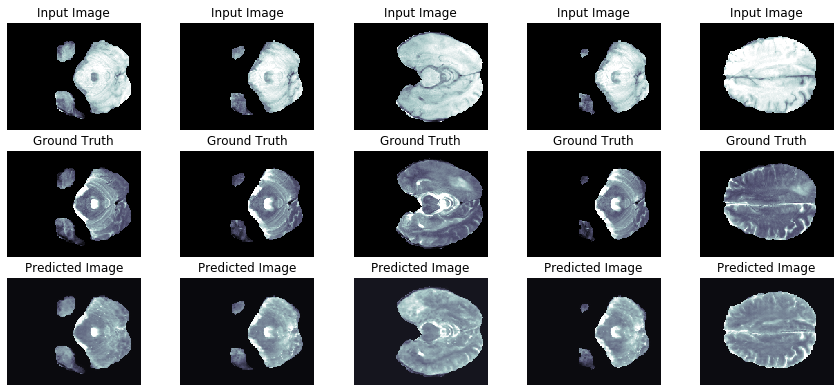


PSNR on validation set: 21.8560 ± 3.9996
MSE on validation set: 0.0090 ± 0.0069
SSIM on validation set: 0.7878 ± 0.1122

PSNR wrt tumor area on validation set: 30.9681 ± 12.7536
MSE wrt tumor area on validation set: 0.0030 ± 0.0041
SSIM wrt tumor area on validation set: 0.9464 ± 0.0562

Time taken for epoch 23 is 416.2124671936035 sec


Epoch:  24
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
....................................................................................................
600
....................

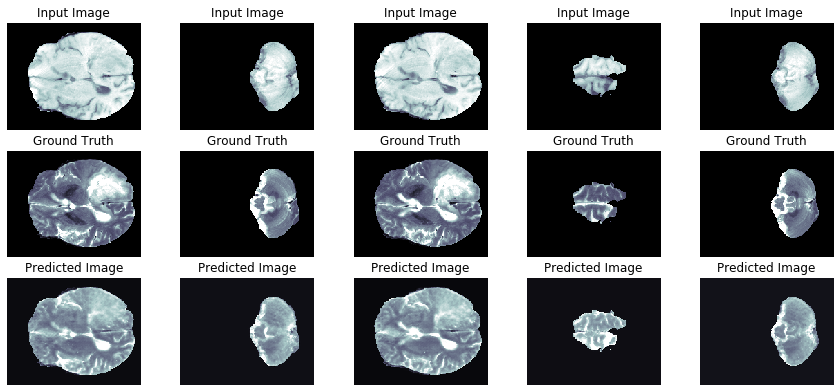


PSNR on validation set: 22.0181 ± 3.7763
MSE on validation set: 0.0083 ± 0.0057
SSIM on validation set: 0.7912 ± 0.1073

PSNR wrt tumor area on validation set: 31.4514 ± 12.7646
MSE wrt tumor area on validation set: 0.0026 ± 0.0034
SSIM wrt tumor area on validation set: 0.9534 ± 0.0465

Time taken for epoch 24 is 414.70401191711426 sec


Epoch:  25
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
....................................................................................................
600
...................

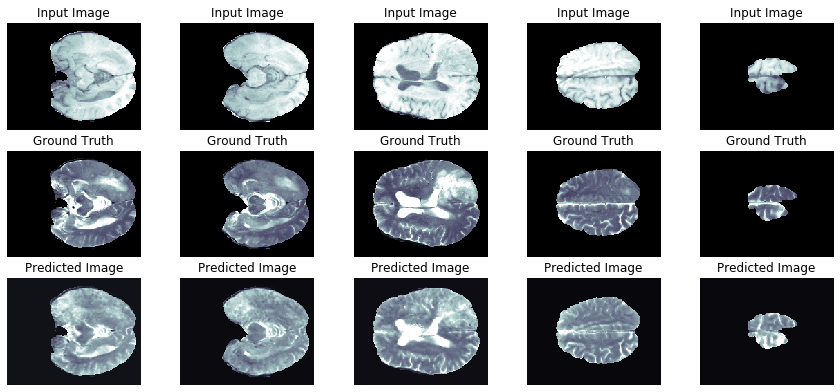


PSNR on validation set: 21.8311 ± 3.8876
MSE on validation set: 0.0088 ± 0.0063
SSIM on validation set: 0.7865 ± 0.1095

PSNR wrt tumor area on validation set: 30.7577 ± 12.1279
MSE wrt tumor area on validation set: 0.0030 ± 0.0039
SSIM wrt tumor area on validation set: 0.9470 ± 0.0534

Saving checkpoint for epoch 25 at ./drive/My Drive/checkpoints/train/ckpt-5
Time taken for epoch 25 is 417.4498858451843 sec


Epoch:  26
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
.................................................

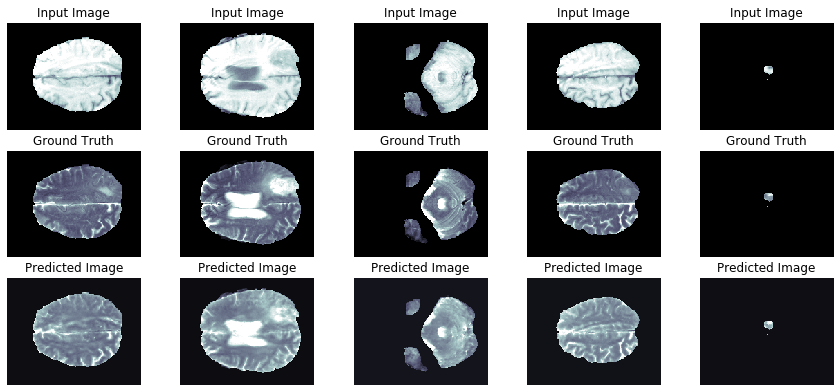


PSNR on validation set: 21.7095 ± 4.0451
MSE on validation set: 0.0093 ± 0.0072
SSIM on validation set: 0.7844 ± 0.1133

PSNR wrt tumor area on validation set: 31.0949 ± 12.7927
MSE wrt tumor area on validation set: 0.0029 ± 0.0038
SSIM wrt tumor area on validation set: 0.9497 ± 0.0513

Time taken for epoch 26 is 414.6016490459442 sec


Epoch:  27
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
....................................................................................................
600
....................

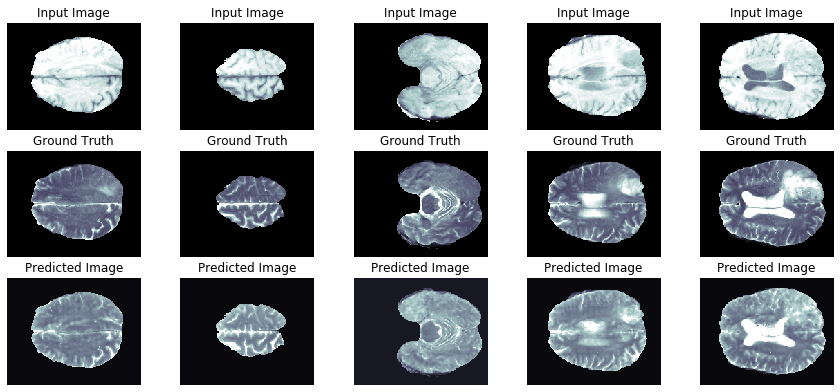


PSNR on validation set: 21.9837 ± 3.9162
MSE on validation set: 0.0085 ± 0.0060
SSIM on validation set: 0.7869 ± 0.1098

PSNR wrt tumor area on validation set: 30.9941 ± 12.9084
MSE wrt tumor area on validation set: 0.0029 ± 0.0037
SSIM wrt tumor area on validation set: 0.9484 ± 0.0505

Time taken for epoch 27 is 414.40643191337585 sec


Epoch:  28
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
....................................................................................................
600
...................

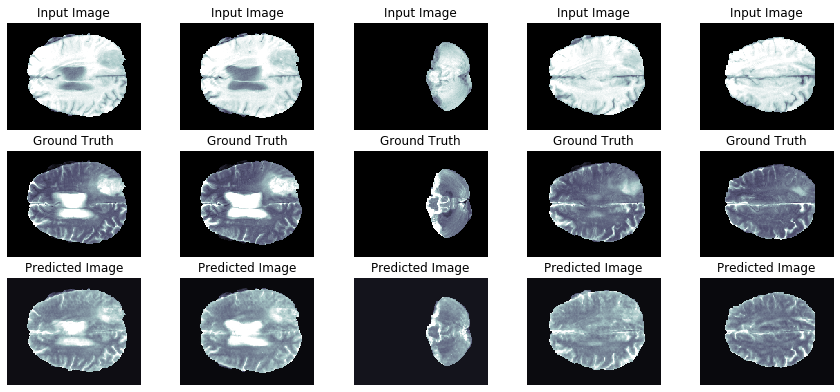


PSNR on validation set: 21.8776 ± 3.9107
MSE on validation set: 0.0087 ± 0.0063
SSIM on validation set: 0.7864 ± 0.1098

PSNR wrt tumor area on validation set: 30.8121 ± 12.4834
MSE wrt tumor area on validation set: 0.0030 ± 0.0039
SSIM wrt tumor area on validation set: 0.9466 ± 0.0529

Time taken for epoch 28 is 414.06444358825684 sec


Epoch:  29
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
....................................................................................................
600
...................

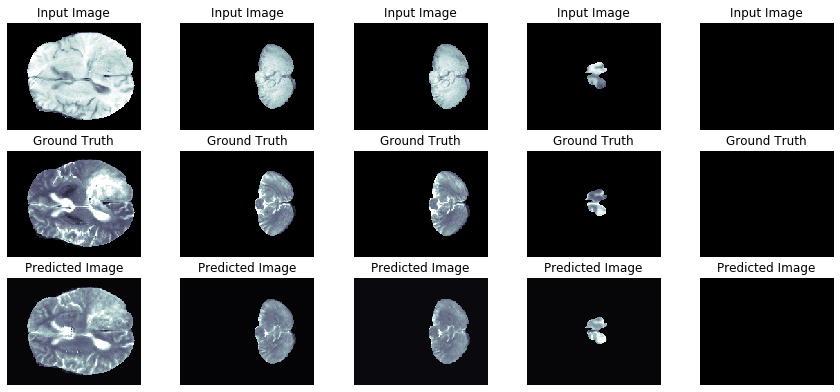


PSNR on validation set: 21.7045 ± 4.1746
MSE on validation set: 0.0097 ± 0.0084
SSIM on validation set: 0.7802 ± 0.1198

PSNR wrt tumor area on validation set: 30.7395 ± 12.7912
MSE wrt tumor area on validation set: 0.0031 ± 0.0039
SSIM wrt tumor area on validation set: 0.9454 ± 0.0545

Time taken for epoch 29 is 414.15099120140076 sec


Epoch:  30
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
....................................................................................................
600
...................

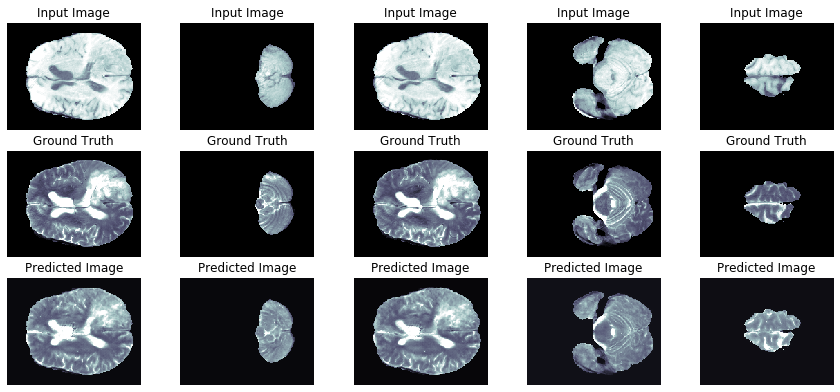


PSNR on validation set: 21.8751 ± 4.0246
MSE on validation set: 0.0089 ± 0.0069
SSIM on validation set: 0.7856 ± 0.1116

PSNR wrt tumor area on validation set: 30.9028 ± 12.5701
MSE wrt tumor area on validation set: 0.0030 ± 0.0038
SSIM wrt tumor area on validation set: 0.9477 ± 0.0510

Saving checkpoint for epoch 30 at ./drive/My Drive/checkpoints/train/ckpt-6
Time taken for epoch 30 is 417.2142379283905 sec


Epoch:  31
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
.................................................

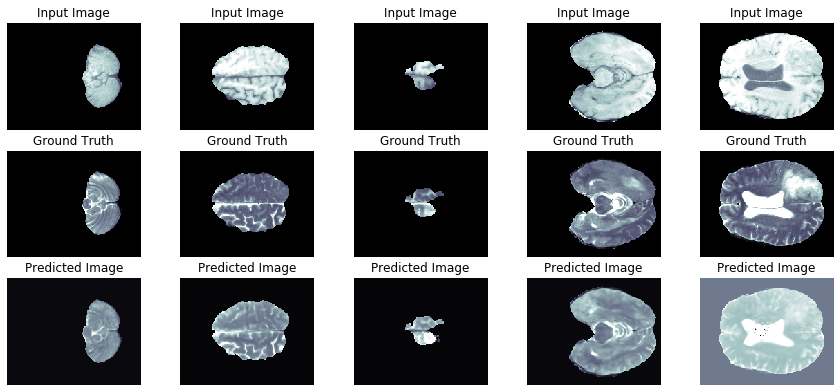


PSNR on validation set: 21.9355 ± 4.2472
MSE on validation set: 0.0093 ± 0.0084
SSIM on validation set: 0.7943 ± 0.1173

PSNR wrt tumor area on validation set: 31.1264 ± 11.4588
MSE wrt tumor area on validation set: 0.0030 ± 0.0040
SSIM wrt tumor area on validation set: 0.9489 ± 0.0555

Time taken for epoch 31 is 413.8184015750885 sec


Epoch:  32
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
....................................................................................................
600
....................

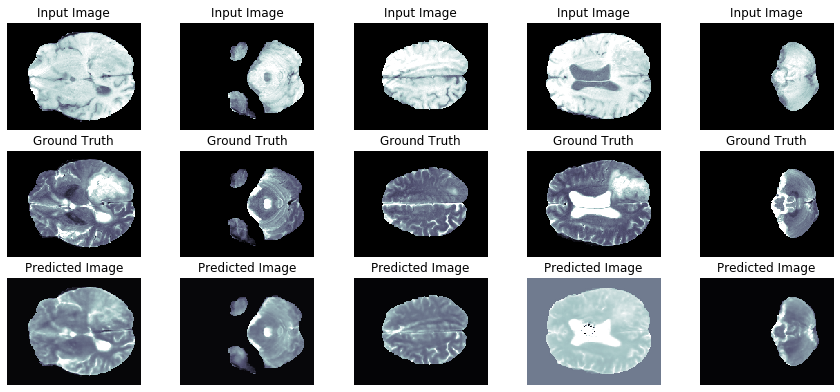


PSNR on validation set: 21.8717 ± 4.5028
MSE on validation set: 0.0100 ± 0.0096
SSIM on validation set: 0.7924 ± 0.1230

PSNR wrt tumor area on validation set: 31.2526 ± 13.0693
MSE wrt tumor area on validation set: 0.0032 ± 0.0047
SSIM wrt tumor area on validation set: 0.9453 ± 0.0656

Time taken for epoch 32 is 413.94727206230164 sec


Epoch:  33
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
....................................................................................................
600
...................

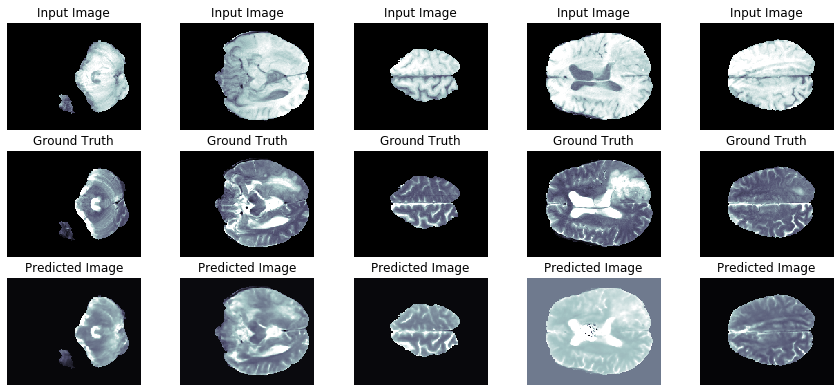


PSNR on validation set: 21.7380 ± 4.3646
MSE on validation set: 0.0099 ± 0.0089
SSIM on validation set: 0.7897 ± 0.1204

PSNR wrt tumor area on validation set: 30.9653 ± 13.1540
MSE wrt tumor area on validation set: 0.0032 ± 0.0046
SSIM wrt tumor area on validation set: 0.9443 ± 0.0635

Time taken for epoch 33 is 414.0394971370697 sec


Epoch:  34
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
....................................................................................................
600
....................

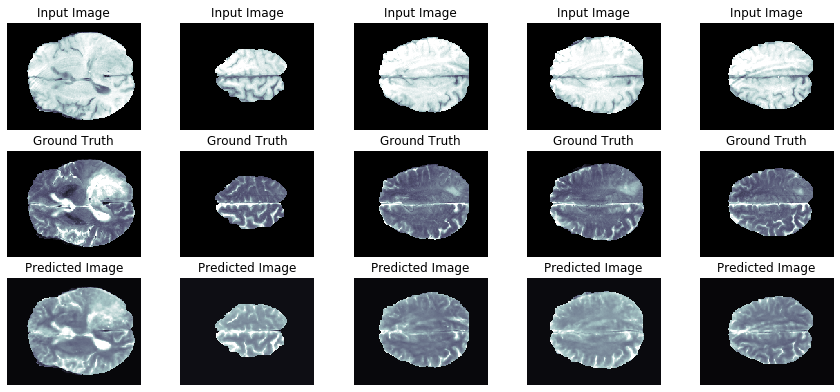


PSNR on validation set: 22.2120 ± 3.9808
MSE on validation set: 0.0081 ± 0.0059
SSIM on validation set: 0.7960 ± 0.1084

PSNR wrt tumor area on validation set: 31.4926 ± 13.0631
MSE wrt tumor area on validation set: 0.0027 ± 0.0035
SSIM wrt tumor area on validation set: 0.9530 ± 0.0471

Time taken for epoch 34 is 414.0143117904663 sec


Epoch:  35
...................................................................................................
100
....................................................................................................
200
....................................................................................................
300
....................................................................................................
400
....................................................................................................
500
....................................................................................................
600
....................

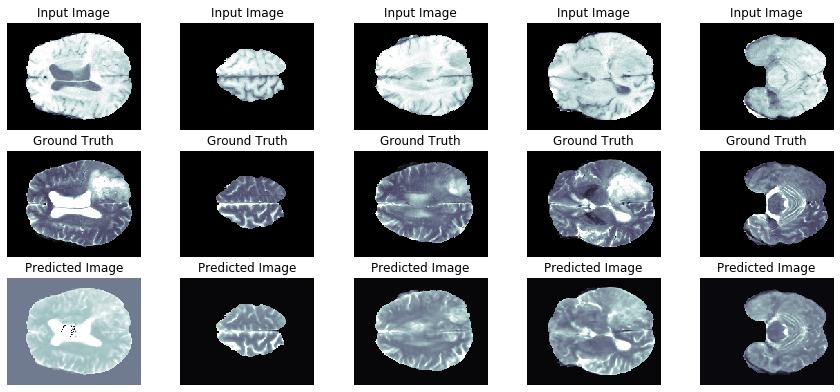


PSNR on validation set: 21.7596 ± 4.5037
MSE on validation set: 0.0102 ± 0.0097
SSIM on validation set: 0.7881 ± 0.1247

PSNR wrt tumor area on validation set: 30.9259 ± 12.0915
MSE wrt tumor area on validation set: 0.0033 ± 0.0048
SSIM wrt tumor area on validation set: 0.9427 ± 0.0677

Saving checkpoint for epoch 35 at ./drive/My Drive/checkpoints/train/ckpt-7
Time taken for epoch 35 is 416.9356999397278 sec

Saving FINAL checkpoint for epoch 35 at ./drive/My Drive/checkpoints/train/ckpt-8


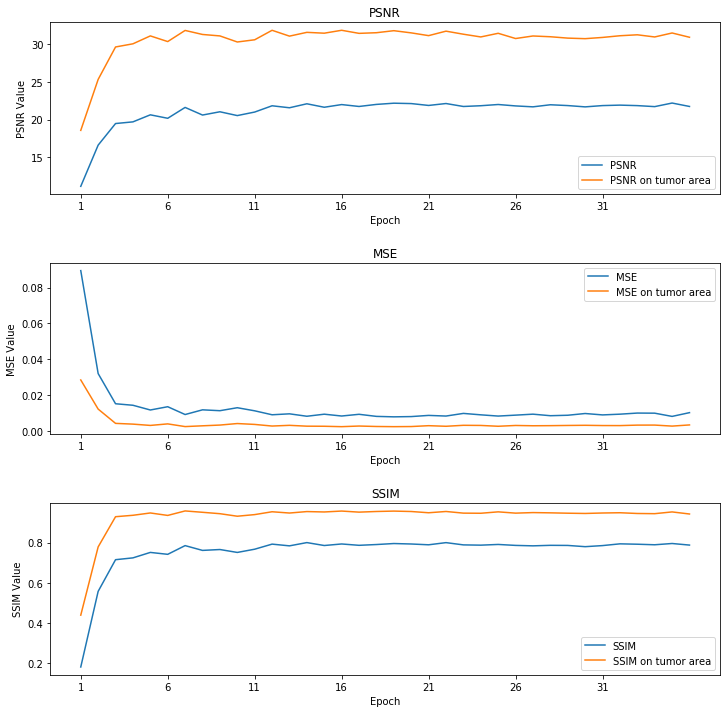

In [39]:
EPOCHS = 35
save_checkpoint = True         # if I want to train without saving checkpoints, then keep the value to False
save_final_models = True
epochs_already_trained = 0      # this is just for the print. 
evaluate_tumor_quality = True

# training, validation, testing = load_datasets() # I'll use this in case I get stuck with the cache.

# Initialize the models, so that I don't have to restart the runtime again.
if evaluate_tumor_quality:
    psnr, mse, ssim, psnr_tumor, mse_tumor, ssim_tumor = fit(training, EPOCHS, validation, save_checkpoint, 
                                                        epochs_already_trained, evaluate_tumor_quality)
    plot_metrics(psnr, mse, ssim, psnr_tumor, mse_tumor, ssim_tumor)

else:
    psnr, mse, ssim = fit(training, EPOCHS, validation, save_checkpoint, 
                                                      epochs_already_trained, evaluate_tumor_quality)
    plot_metrics(psnr, mse, ssim)

# at the end, I'll save the models (I would need only the gen, but let's sayve also the disc  )
# (it saves the entire model to a HDF5 file)

if save_final_models:
    generator.save('drive/My Drive/MRI-generation/gen_test2.h5')
    discriminator.save('drive/My Drive/MRI-generation/disc_test2.h5') 

##Evaluating the final model with the test set

In [0]:
# Let's check the scores of this model.

evaluate_GAN(generator, testing, 'test', True)

## Considerations about metrics and normalization

In [0]:
training, validation, testing = load_datasets() # I'll use this in case I get stuck with the cache.

In [0]:
for raw_record in testing.take(1):
    inp, ground_truth = take_images_from_raw(raw_record)

    prediction = generator(inp, training=False)
    inp, ground_truth, prediction = resize_with_crop(inp, ground_truth, prediction)

    prediction_normalized = mean_normalize(prediction)
    ground_truth_normalized = mean_normalize(ground_truth) 

    #prediction_normalized2 = min_max_normalize(prediction)
    
    # remove black images from ground_truth is not that necessary because it's enough to do it on the predictions. 
    # Anyway, just to be sure, let's remove them also from the ground truth (so the metrics of those images will be ignored)

    # BLACK IMAGES ARE DISCARDED IN ALL THE METRICS COMPUTED. Both in the case where I normalize and in the one in which I don't.
    # What if, in the case in which I don't normalize, I keep the black images? We would have significant differences.
    # For example PSNR would be 27.0207 ± 10.2544 instead of  25.2498 ± 2.8603 (with the model trained)
    ground_truth = black_images_to_nan(ground_truth)
    prediction = black_images_to_nan(prediction)

    #mean, std, psnr = compute_psnr(ground_truth, prediction_normalized2)
    #print("PSNR w/ min-max norm: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))
    mean, std, psnr = compute_psnr(ground_truth_normalized, prediction_normalized)
    print("PSNR w/ mean-norm: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))
    mean, std, psnr = compute_psnr(ground_truth, prediction)
    print("PSNR: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))
    print()
    #mean, std, ssim = compute_ssim(ground_truth, prediction_normalized2)
    #print("SSIM w/ min-max norm: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))
    mean, std, ssim = compute_ssim(ground_truth_normalized, prediction_normalized)
    print("SSIM w/ mean-norm: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))
    mean, std, ssim = compute_ssim(ground_truth, prediction)
    print("SSIM: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))
    print()
    #mean, std, mse = compute_mse(ground_truth, prediction_normalized2)
    #print("SSIM w/ min-max norm: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))
    mean, std, mse = compute_mse(ground_truth_normalized, prediction_normalized)
    print("MSE w/ mean-norm: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))
    mean, std, mse = compute_mse(ground_truth, prediction)
    print("MSE: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))

PSNR w/ mean-norm: 9.9567 ± 1.6729
PSNR: 10.7538 ± 2.3098

SSIM w/ mean-norm: -0.2650 ± 0.0672
SSIM: 0.5875 ± 0.1685

MSE w/ mean-norm: 0.1084 ± 0.0392
MSE: 0.0962 ± 0.0482


## Additional notes

In [0]:
# in the testing there are 28 patients so 128*28 = 3584 samples
# with a batch_size of 32, we have 112 elements in the prefetched TEST set so 3584 samples.
# in the VALIDATION SET: 108 elements * 32 (batch_size) = 3456 samples.
# in the TRAINING set: 876 elements * 32 = 28032

# each samples has then all the scans defined in the load_dataset (up to 4 scans + the segmented area)
# if batch size is set to 32, then there are less then 100 samples.

# training: with GPU it crashes, with TPU works. a bit more of 28000 samples -> 219 patients * 128 levels.

# training with 100 samples, batch size = 1 and TPU took 46 seconds
# training with 100 samples, batch size = 1 and GPU took 7/8 seconds

# training with 1000 samples, batch size = 1, resizing to 256, GPU took 54 seconds
# training with 1000 samples, batch size = 1, padding to 256, GPU took 52 seconds

# TRAINING TIMES WITH DIFFERENT BATCH SIZES:
# training with 16 samples and batch size = 64 (so 1024 samples fed to the GAN), TPU took 209 seconds

# training with 1000 samples and batch size = 1 (so 1000 samples fed to the GAN), GPU took about 490 seconds (8 min)
# training with 250 samples and bs = 4 (so 1000 samples fed to the GAN), GPU took 127 seconds!
# training with 128 samples and bs = 8 (so 1024 samples fed to the GAN), GPU took 75 seconds!
# training with 64 samples and bs = 16 (so 1024 samples fed to the GAN), GPU took 41 seconds!
# training with 31 samples and bs = 32 (so still 992 samples fed to the GAN), GPU took 28/32/33
# training with 16 samples and bs = 64 (so 1024 samples fed to the GAN), GPU took 23/25/26 seconds!

# training with 8 samples and bs = 128, GPU took 24/25( 21 in the most recent) sec! -> not so good quality
# (It has been observed in practice that when using a larger batch there is a significant degradation in the 
# quality of the model, as measured by its ability to generalize.)
# https://stats.stackexchange.com/questions/164876/tradeoff-batch-size-vs-number-of-iterations-to-train-a-neural-network

# The resulting model may not generalize as well as a model trained with a small batch size

# tradeoff between 32 and 64. 32 seems to be qualitatively more accurate but it's a bit slower. 
# before choosing, it would be better to implement also the quantitative metrics.

# from pix2pix paper: use batch sizes between 1 and 10 depending on the experiment


# In general, batch size of 32 is a good starting point, and you should also try with 64, 128, and 256. 
# Other values (lower or higher) may be fine for some data sets, but the given range is generally the best to 
# start experimenting with. Though, under 32, it might get too slow because of significantly lower computational speed, 
# because of not exploiting vectorization to the full extent.  
# If you get an "out of memory" error, you should try reducing the mini-batch size anyway.


# training with 4 samples and bs = 256, GPU run out of memory. Resource exhausted.

In [0]:
# np.FUNCTION VS tf.FUNCTION

# np =  training with 31 samples and bs = 32 (992 samples fed to the GAN), GPU took 28/32/33
# training with 32 samples and bs = 32 (1024 samples fed to the GAN), GPU took 14/15/16/17 seconds 